# Approximate(Deep) Q-Learning
## Using TF-1.x
### Tested on CartPole-v0

##### Tried an oop approach, but I am not sure about TF1 graph flows

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Start the environment
env = gym.make("CartPole-v0").env

## TF Stuff to do beforehand

In [4]:
#TF stuff
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.compat.v1.keras as keras
import tensorflow.compat.v1.keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
#Checking GPU Use
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/device:GPU:0


## Create AQL Agent

### The loss function for our agent is defined as - 
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$

Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

Since $Q_{-}(s',a')$ is kept constant for our semi-grad Q-Learning, we will use `tf.stop_gradient` for this

In [6]:
class AQLAgent:
    def __init__(self, env, epsilon=0.5, gamma=0.99, load=False):
        '''
        Use load=True to load a previously saved model
        '''
        #Set up constants
        self.state_dim = env.observation_space.shape
        self.n_actions = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.env = env
        #Set up model
        if load:
            self.model = keras.models.load_model('./models/cart_model.h5')
            print("Model loaded")
        else:
            self.model = self.create_model()
            self.model.save('./models/cart_model.h5')
            #Print out some details
            print(self.model.summary())
        
        #Placeholders for <s,a,r,s'> and game_end
        self.states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + self.state_dim)
        self.actions_ph = keras.backend.placeholder(dtype='int32', shape=[None])
        self.rewards_ph = keras.backend.placeholder(dtype='float32', shape=[None])
        self.next_states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + self.state_dim)
        self.is_done_ph = keras.backend.placeholder(dtype='bool', shape=[None])
        
        #Then performing Q-Learning we have
        
        #Get 𝑄𝜃(s,a)
        self.pred_q = self.model(self.states_ph)
        self.pred_q_for_a = tf.reduce_sum(self.pred_q * tf.one_hot(self.actions_ph, self.n_actions), axis=1)
        
        #Get Q_(s',a')
        self.pred_next_q = self.model(self.next_states_ph)
        #Get V_(s',a') using Q
        self.next_v = tf.math.reduce_max(self.pred_next_q, axis=1)
        #Get target Q-value, Q_(s',a')
        self.target_q_for_a = self.rewards_ph + self.gamma*self.next_v
        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        self.target_q_for_a = tf.where(self.is_done_ph, self.rewards_ph, self.target_q_for_a)
        
        #Calculate loss
        self.loss = (self.pred_q_for_a - tf.stop_gradient(self.target_q_for_a)) ** 2
        self.loss = tf.reduce_mean(self.loss)
        
        #Training function
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)   
        
        if load: 
            self.model.load_weights('./weights/cart_weights')
            print("Model weights loaded succesfully")
        
    def create_model(self):
        '''
        Create a simple NN model
        '''
        model = keras.models.Sequential()
        model.add(L.InputLayer(self.state_dim))
        model.add(L.Dense(400, kernel_initializer='uniform', activation='relu'))
        model.add(L.Dense(400, kernel_initializer='uniform', activation='relu'))
        #Output layer
        model.add(L.Dense(self.n_actions, kernel_initializer='uniform', activation='linear'))
        return model
        
    def get_action(self, state):
        '''
        Uses E-greedy policy to get the agent action
        '''
        #Approximate the q_values
        q_values = self.model.predict(state[None])[0]
        #Explore or exploit
        ore_or_oit = np.random.choice([0,1], p =[self.epsilon, 1-self.epsilon])
        #If wanna explore
        if ore_or_oit == 0:
            chosen_action = np.random.choice(self.n_actions, 1)[0] #Over uniform dist
        #If wanna exploit
        else:
            chosen_action = np.argmax(q_values)
            
        return chosen_action
    
    def generate_session(self, t_max=1000, train=False):
        '''
        Run environment and train
        '''
        total_reward = 0
        s = self.env.reset()

        for t in range(t_max):
            a = self.get_action(s)       
            next_s, r, done, _ = self.env.step(a)

            if train:
                sess.run(self.train_step,{
                    self.states_ph: [s], self.actions_ph: [a], self.rewards_ph: [r], 
                    self.next_states_ph: [next_s], self.is_done_ph: [done]})

            total_reward += r
            s = next_s
            if done:
                break

        return total_reward
    
    def save(self):
        '''
        Save the weights
        '''
        self.model.save_weights('./weights/cart_weights')

In [ ]:
agent = AQLAgent(env)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Time to train and run

In [1]:
sess.run(tf.global_variables_initializer())

NameError: name 'sess' is not defined

epoch #2	mean reward = 14.160	epsilon = 0.485


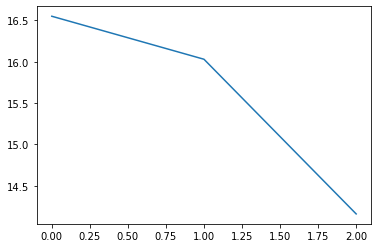

KeyboardInterrupt: 

In [9]:
from IPython.display import clear_output

mean_rewards = []

for i in range(10000):
    session_rewards = [agent.generate_session(train=True) for _ in range(100)]
    mean_rewards.append(np.mean(session_rewards))
    agent.epsilon *= 0.99
    clear_output(True)
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), agent.epsilon))
    plt.plot(mean_rewards)
    plt.show()
    #Save weights after every iteration
    agent.save()
    if np.mean(session_rewards) > 300:
        print("You Win! Stop using Keyboard Interrupt")
#         break

In [18]:
agent.save()

In [16]:
# Record sessions
import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    agent.env = env_monitor
    sessions = [agent.generate_session(train=False) for _ in range(10)]

In [17]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

In [1]:
state

NameError: name 'state' is not defined